<a href="https://colab.research.google.com/github/Wanita-8943/Project_2023/blob/main/M3_Train_Freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##เรียกใช้ CSV

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [3]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 837, done.
remote: Total 837 (delta 0), reused 0 (delta 0), pack-reused 837
Receiving objects: 100% (837/837), 13.85 MiB | 24.50 MiB/s, done.
Resolving deltas: 100% (497/497), done.
/content/efficientnet_keras_transfer_learning


In [4]:
df = pd.read_csv (r'/content/drive/MyDrive/cut_panoramic/Data/New_Data_Male125.csv')
df

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
0,1,1,7,Y07M,0,VV03.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
1,2,1,7,Y07M,0,Flip_VV03.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
2,3,2,7,Y07M,0,VV04.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
3,4,2,7,Y07M,0,Flip_VV04.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
4,5,3,7,Y07M,0,VV05.jpg,/content/drive/My Drive/TVT_Male125/train/Y07M...,เพศชาย,Both
...,...,...,...,...,...,...,...,...,...
2370,121,77,25,Y25M,18,Flip_J463.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2371,122,78,25,Y25M,18,J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2372,123,78,25,Y25M,18,Flip_J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2373,124,79,25,Y25M,18,J465.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both


In [5]:
import sys
sys.path.append('/content/drive/My Drive/cut_panoramic/Model/Classification/Male/M3_Train_Freeze.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [6]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/cut_panoramic/Model/Classification/Male/M3_Train_Freeze.h5')
height = width = model.input_shape[1]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
base_dir = '/content/drive/MyDrive/TVT_Male125'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [8]:
batch_size = 16

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

#label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 1425 images belonging to 19 classes.
{0: 'Y07M', 1: 'Y08M', 2: 'Y09M', 3: 'Y10M', 4: 'Y11M', 5: 'Y12M', 6: 'Y13M', 7: 'Y14M', 8: 'Y15M', 9: 'Y16M', 10: 'Y17M', 11: 'Y18M', 12: 'Y19M', 13: 'Y20M', 14: 'Y21M', 15: 'Y22M', 16: 'Y23M', 17: 'Y24M', 18: 'Y25M'}


In [9]:
test = df[df['Fig_Age'].between(101,125)]
test

,Fig_Age,Fig_Person_Sex,Age(year),Class,Class_Re,Filename,Path_filename,Sex,Floder
100,101,51,7,Y07M,0,VV83.jpg,/content/drive/My Drive/TVT_Male125/test/Y07M/...,เพศชาย,Both
101,102,51,7,Y07M,0,Flip_VV83.jpg,/content/drive/My Drive/TVT_Male125/test/Y07M/...,เพศชาย,Both
102,103,52,7,Y07M,0,VV84.jpg,/content/drive/My Drive/TVT_Male125/test/Y07M/...,เพศชาย,Both
103,104,52,7,Y07M,0,Flip_VV84.jpg,/content/drive/My Drive/TVT_Male125/test/Y07M/...,เพศชาย,Both
104,105,53,7,Y07M,0,VV85.jpg,/content/drive/My Drive/TVT_Male125/test/Y07M/...,เพศชาย,Both
...,...,...,...,...,...,...,...,...,...
2370,121,77,25,Y25M,18,Flip_J463.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2371,122,78,25,Y25M,18,J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2372,123,78,25,Y25M,18,Flip_J464.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both
2373,124,79,25,Y25M,18,J465.jpg,/content/drive/My Drive/TVT_Male125/test/Y25M/...,เพศชาย,Both


In [10]:
act = test['Class'].tolist() #ค่าจริง
path = test['Path_filename'].tolist() #path

In [11]:
# act

In [12]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width)) #รูปทุกรูปมีขนาดไม่เท่ากันจึงตั้งไว้ว่าเวลาจะให้ model ดึงรูปมาทำนายให้ดึงรูปเข้ามาตามขนาดที่ตั้งไว้ตามพารามิตเตอร์
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)  #model ไม่สามารถทำนายรูปภาพโดยตรงได้ จึงเเปลงรูปภาพให้เป็น array เเล้วให้โมเดลทำนาย
    # Reshape
    x = x.reshape((1,) + x.shape) # เพิ่ม ไดเมนชั่นของโมเดล ให้เป็น 4 ได้ เมนชั่น โดยที่ 1, คือบอกให้โมเดลนำเข้าทีละ 1 รูปเเล้วค่อยทำนาย เเละ + ไดเมนชั่น คือ 150 ,150 ,3(สีของ RGB)
    x /= 255.
    result = model.predict([x])
    return result[0]

In [13]:
predict_image(path[0])

1/1 [==============================] - 9s 9s/step


array([8.6109060e-01, 3.8920756e-02, 7.8581311e-02, 1.7053368e-02,
       3.6696093e-03, 6.7185890e-04, 1.1458291e-05, 4.1399836e-08,
       2.2474649e-07, 4.2549942e-07, 4.3345299e-08, 7.0083679e-08,
       1.5137129e-08, 1.3816413e-08, 1.0138967e-08, 1.1968152e-08,
       5.1744326e-08, 7.6205486e-09, 1.5067535e-08], dtype=float32)

In [14]:
no = np.argmax(predict_image(path[0]))
labels[no]

1/1 [==============================] - 0s 30ms/step


'Y07M'

In [15]:
#Predict
pred_list = list()
prob_list = list()
img_path= path
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    result = np.argmax(predict)
    pred_list.append(labels[result])
    prob_list.append(predict[result])

1/1 [==============================] - 0s 32ms/step


In [16]:
pred_list

['Y07M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y07M',
 'Y07M',
 'Y09M',
 'Y07M',
 'Y09M',
 'Y07M',
 'Y09M',
 'Y09M',
 'Y07M',
 'Y07M',
 'Y07M',
 'Y07M',
 'Y09M',
 'Y07M',
 'Y07M',
 'Y07M',
 'Y10M',
 'Y07M',
 'Y07M',
 'Y09M',
 'Y08M',
 'Y09M',
 'Y08M',
 'Y07M',
 'Y09M',
 'Y10M',
 'Y09M',
 'Y08M',
 'Y07M',
 'Y10M',
 'Y08M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y10M',
 'Y10M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y08M',
 'Y07M',
 'Y12M',
 'Y09M',
 'Y08M',
 'Y09M',
 'Y09M',
 'Y10M',
 'Y10M',
 'Y09M',
 'Y10M',
 'Y08M',
 'Y09M',
 'Y10M',
 'Y08M',
 'Y10M',
 'Y10M',
 'Y10M',
 'Y10M',
 'Y10M',
 'Y09M',
 'Y09M',
 'Y08M',
 'Y08M',
 'Y07M',
 'Y08M',
 'Y08M',
 'Y11M',
 'Y11M',
 'Y10M',
 'Y09M',
 'Y08M',
 'Y09M',
 'Y09M',
 'Y09M',
 'Y10M',
 'Y10M',
 'Y09M',
 'Y09M',
 'Y10M',
 'Y10M',
 'Y09M',
 'Y10M',
 'Y07M',
 'Y09M',
 'Y11M',
 'Y11M',
 'Y09M',
 'Y11M',
 'Y09M',
 'Y09M',
 'Y11M',
 'Y11M',
 'Y12M',
 'Y12M',
 'Y11M',
 'Y10M',
 'Y11M',
 'Y09M',
 'Y10M',
 'Y10M',
 'Y11M',
 'Y12M',
 

In [17]:
prob_list[0]

0.8610906

In [18]:
# data_train = valframe
# #เช็คคลาสใน Predicted
# pred_class = set(data_train['category_ov'])
# print('Predicted : ',len(pred_class))
# print(pred_class)
# print('-'*50)
# #เช็คคลาสใน Actual
# classe = set(data_train['class'])
# print('Actual : ',len(classe))
# print(classe)

In [19]:
pred = np.array(pred_list) #แปลงเป็น array
act = np.array(act)

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

# act = data_train['class'].array
# pred = data_train['category_ov'].array

cmat = confusion_matrix(act, pred)
print('classifier accuracy = {}%'.format((100.*np.trace(cmat))/(np.sum(cmat))))

#Marking the Confusion Matrix
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(act, pred))#performance

classifier accuracy = 17.05263157894737%
              precision    recall  f1-score   support

        Y07M       0.60      0.48      0.53        25
        Y08M       0.38      0.20      0.26        25
        Y09M       0.15      0.28      0.19        25
        Y10M       0.16      0.24      0.19        25
        Y11M       0.21      0.36      0.26        25
        Y12M       0.09      0.32      0.14        25
        Y13M       0.19      0.28      0.23        25
        Y14M       0.07      0.04      0.05        25
        Y15M       0.00      0.00      0.00        25
        Y16M       0.07      0.04      0.05        25
        Y17M       0.19      0.12      0.15        25
        Y18M       0.40      0.16      0.23        25
        Y19M       0.17      0.24      0.20        25
        Y20M       0.00      0.00      0.00        25
        Y21M       0.08      0.08      0.08        25
        Y22M       0.20      0.04      0.07        25
        Y23M       0.12      0.12      0

Text(0.5, 66.5, 'Predicted label')

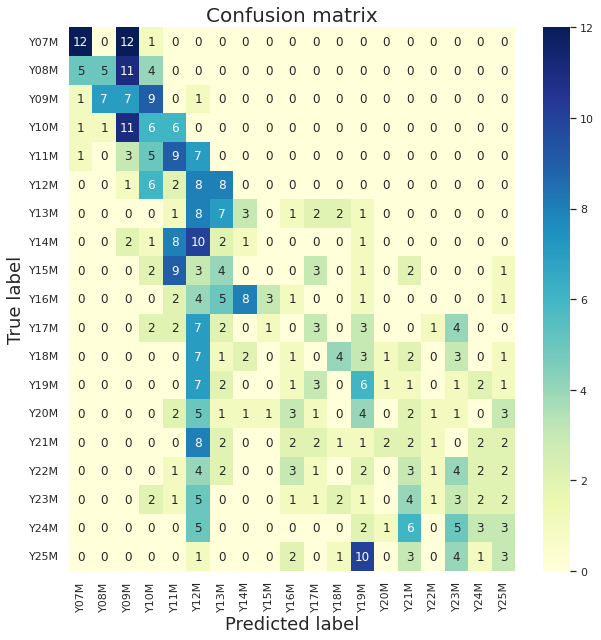

In [21]:
#create CF 
data = {'Actual': act,'Predicted' : pred,}
df = pd.DataFrame(data, columns=['Actual','Predicted'])
conf_mat = pd.crosstab(df['Actual'],df['Predicted'],rownames=['Actual'],colnames=['Predicted'])

#Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(act, pred)

#plot Confusion matrix
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 10))

ax = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="YlGnBu") #Blues,Oranges,Reds
ax.set_title('Confusion matrix',fontsize=20)
ax.set_ylabel('True label',fontsize=18)
ax.set_xlabel('Predicted label',fontsize=18)